# Current Amplifier Output Calibration

This script converts current_output_cal_functions into the OutputChannel() class for easier re-use (to cal Channel U and Channel V). Hopefully this serves as a starting point for my calibration routines, making them easier to convert to python-tcal

In [1]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pyvisa as visa
import struct
from pathlib import Path
from scipy.interpolate import interp1d

from saveCalData import saveMeasurement
from progressbar import update_progress

In [2]:
def serialQry(port, command):
    port.reset_input_buffer()
    port.write((command + '\n').encode('ascii'))
    return port.readline().decode('ascii').strip() #strip removes white space

def serialCmd(port, command):
    port.reset_input_buffer()
    port.write((command + '\n').encode('ascii'))

In [3]:
def rms(x):
    return np.sqrt(np.mean(x**2))

In [4]:
sr542 = serial.Serial(port='COM11', baudrate=115200, timeout=.5)
sr542.set_buffer_size(24570)
cs580 = serial.Serial(port='COM10', baudrate=9600, timeout=0.5)
rm = visa.ResourceManager()
rm.list_resources()
dvm = rm.open_resource('USB0::0x0957::0xB318::MY52449038::INSTR')

In [5]:
print(serialQry(sr542, '*IDN?'))
print(serialQry(cs580, '*IDN?'))
print(dvm.query('*IDN?'))

Stanford_Research_Systems, SR542, s/n00001007, v0.10
Stanford_Research_Systems,CS580,s/n137132,ver1.14
Agilent Technologies,34450A,MY52449038,00.56-00.63



In [6]:
sr542.get_settings()

{'baudrate': 115200,
 'bytesize': 8,
 'parity': 'N',
 'stopbits': 1,
 'xonxoff': False,
 'dsrdtr': False,
 'rtscts': False,
 'timeout': 0.5,
 'write_timeout': None,
 'inter_byte_timeout': None}

# Define Cal Functions

In [7]:
class OutputChannel():
    def __init__(self, channel):
        if channel == 'U' or channel == 'V':
            self.channel = channel
        else:
            raise ValueError('Invalid channel assignment')
        
        # Default all values to ideal or nominal
        self.R = 0.1 # ohms
        self.Vref = 3.3 # volts
        self.dacBits = 12
        self.numCodes = 2**self.dacBits
        self.R_f = 10e3 # ohms
        self.R_in = 90.9e3 # ohms
        self.R_sense_nom = 0.1 # ohms
        self.HowlandGain = self.R_f/(self.R_in*self.R_sense_nom)
        self.LSB_A = self.Vref/self.numCodes*self.HowlandGain # LSB size, in Amps
        self.LUT = np.arange(0, self.numCodes, 1) # The Correction LUT
        self.idealCurrent = np.poly1d([self.Vref/self.numCodes, -self.Vref/2])*self.HowlandGain # linear current output defined by [slope, offset]
        self.allCodes = self.LUT
        self.txFun = self.idealCurrent(self.allCodes) # The Measured Transfer Function: txFun[code] = output (A)
        self.cald = False
        self.passed = False
        
    def CurrentToLsb(self, I_A):
        return I_A/self.LSB_A

    def LsbToCurrent(self, bits):
        return bits*self.LSB_A
        
    def SweepI_MeasV(self, I_init, I_final, I_step):        
        I_sweep = np.arange(I_init, I_final + I_step, I_step)

        serialCmd(cs580, 'GAIN G50mA')
        serialCmd(cs580, f'CURR {I_init:.3f}')
        serialCmd(cs580, 'INPT OFF')
        serialCmd(cs580, 'SOUT ON')

        time.sleep(1.0)
        V_meas = []

        for curr in I_sweep:
            serialCmd(cs580, f'CURR {curr:.3f}')
            time.sleep(1.0)
            V_meas.append(float(dvm.query('MEAS:VOLT:DC? 0.1, 3e-5').strip('\n')))
            
            update_progress(len(V_meas) / len(I_sweep))

        serialCmd(cs580, 'CURR 0')
        serialCmd(cs580, 'SOUT OFF')

        coeffs, cov = np.polyfit(I_sweep, V_meas, 1, cov=True)
        fit = np.poly1d(coeffs)
        R_meas = coeffs[0]
        R_std = np.sqrt(np.diag(cov))[0]
        print(f'R = {R_meas:.5e} +- {R_std:.5e} Ohms')
        
        plt.plot(I_sweep, V_meas, '.')
        plt.plot(I_sweep, fit(I_sweep), label=f'fit: R={coeffs[0]:.6} Ohms')
        plt.xlabel('applied current (A)')
        plt.ylabel('meas voltage (V)')
        plt.legend()   
        plt.title('4 pt I-V Resistance Measurement')
        
        # define reasonable measurement bounds: +/- 10%
        if (R_meas > 1.1*self.R_sense_nom) or (R_meas < 0.9*self.R_sense_nom):
            print('Resistance measurement out-of-spec')
            return
        else:
            self.R = R_meas

    def MeasVoltageVsDacCode(self, codes):
        serialCmd(sr542, '$CEN ON')
        #time.sleep(30.0) # TODO: do I still need this?

        t0 = time.time()

        V_sense = []
        for dacCode in codes:
            if(self.channel=='U'):
                serialCmd(sr542, f'$SUV {dacCode}, 2048')
            elif(self.channel=='V'):
                serialCmd(sr542, f'$SUV 2048, {dacCode}')
            else:
                print('Invalid Channel')
                break

            time.sleep(0.1) #TODO: how long to sleep here?
            V = float(dvm.query('MEAS:VOLT:DC? 10, 1.5e-6')) #voltage measured across ~R_sense
            #print(f'{dacCode}, {V}')
            V_sense.append(V) 

            update_progress(len(V_sense) / len(codes))
            
        # Zero the output and turn the Current Source off
        serialCmd(sr542, '$SUV 2048, 2048')
        serialCmd(sr542, '$CEN OFF')

        print(f'elapsed time = {time.time() - t0}')

        return np.array(V_sense)
    
    def MeasuredVoltageToCurrentError(self, codes, V_meas):
        I_A_meas = V_meas/self.R 
        I_A_error = I_A_meas - self.idealCurrent(codes)
        I_c_error = I_A_error/self.LSB_A
        
        return I_c_error

    def PlotCurrentError(self, codes, V_meas):    
        #I_A = V_meas/self.R
        #I_A_error = I_A - self.idealCurrent(codes)
        #I_c_error = I_A_error/self.LSB_A
        I_c_error = self.MeasuredVoltageToCurrentError(codes, V_meas)

        minor_ticks = np.arange(int(min(I_c_error)), int(max(I_c_error)) + 1, 1)

        fig, axL = plt.subplots(figsize=(8,8))
        axL.plot(codes, I_c_error, '.', label='measured error')
        if self.cald:
            axL.plot(self.allCodes, (self.txFun[self.LUT[self.allCodes]] - self.idealCurrent(self.allCodes))/self.LSB_A, 
                     label='expected error')        
        axL.set_xlabel('dac code')
        axL.set_ylabel('output error (LSBs)')    
        axL.set_yticks(minor_ticks, minor=True)
        axL.grid('y')
        axL.grid('y', which='minor', alpha=0.5)
        axL.set_title(f'Channel {self.channel} Output Error')
        axL.legend()

        axR = axL.secondary_yaxis('right', functions=(self.LsbToCurrent, self.CurrentToLsb))
        axR.grid(axis='y')
        axR.set_ylabel('output error (A)')
        
    def PlotComparison(self, codes, V_meas, labels):
        # Expects a list of codes and a list of measurements to be able to compare multiple measurements

        numOfCodeSweeps = len(codes)
        numOfMeasurementSweeps = len(V_meas)

        if numOfCodeSweeps != numOfMeasurementSweeps:
            print('Improper number of measurements') 
            return

        fig, axL = plt.subplots(figsize=(8,8))
        for i in range(numOfCodeSweeps):
            #I_A = V_meas[i]/self.R
            #I_A_error = I_A - self.idealCurrent(codes[i])
            #I_c_error = I_A_error/self.LSB_A
            I_c_error = self.MeasuredVoltageToCurrentError(codes[i], V_meas[i])
            axL.plot(codes[i], I_c_error, label=labels[i])
            
        axL.set_xlabel('dac code')
        axL.set_ylabel('output error (LSBs)')
        axL.grid('y')
        axL.legend()
        axL.set_title(f'Channel {self.channel} Output Error Comparison')
        
        axR = axL.secondary_yaxis('right', functions=(self.LsbToCurrent, self.CurrentToLsb))        
        axR.set_ylabel('output error (A)')
        
    def CreateLUT(self, codes, V_meas):
        V_meas_interp = interp1d(codes, V_meas, kind='cubic')
        I_c_error = self.MeasuredVoltageToCurrentError(self.allCodes, V_meas_interp(self.allCodes))
        #I_A = V_meas/self.R
        #cubicSpline = interp1d(codes, I_A, kind='cubic')
        #error_A = cubicSpline(self.allCodes) - self.idealCurrent(self.allCodes)
        #error_c = error_A/self.LSB_A # error in number of LSBs (or codes)                

        self.LUT = np.rint(np.clip(self.allCodes - I_c_error, 0, 4095)).astype(np.int16)           
        #self.txFun = cubicSpline(self.allCodes)
        self.txFun = V_meas_interp(self.allCodes)/self.R
        self.cald = True

        return I_c_error

    def ApplyLUTCorrection(self):
        plt.figure(figsize=(8,8))
        
        plt.plot(self.allCodes, (self.txFun[self.allCodes] - self.idealCurrent(self.allCodes))/self.LSB_A, '.', label='uncal')
        plt.plot(self.allCodes, (self.txFun[self.LUT[self.allCodes]] - self.idealCurrent(self.allCodes))/self.LSB_A, label='LUT correction')        
        plt.grid(axis='y')
        plt.xlabel('dac code')
        plt.ylabel('output error (LSBs)')
        plt.legend()
        plt.title('Expected Calibrated Output Error')
        
    def EvaluatePassFail(self, dacCodes, V_meas):
        error_A = V_meas/self.R - self.idealCurrent(dacCodes)
        
        rms_error_LSB = rms(error_A/self.LSB_A)       
            
        print(f'rms error = {rms(error_A/self.LSB_A):.3f} LSBs')
        
        if rms_error_LSB < 3: # TODO: what to set this to?
            self.passed = True
            print('Calibration Passed!')
        else:
            self.passed = False
            print('Calibration Failed')
            
        return self.passed
            
    def UploadCalData(self, LUT = None):
        if LUT is None:
            LUT = self.LUT
        t0 = time.time()        
        serialCmd(sr542, f'$DAA CH{self.channel}')
        # This causes the firmware to entire a blocking state where
        # it expects *exactly* 4096 words (8192 bytes)
        for i in range(4096):
            bytesToWrite = struct.pack('<h', LUT[i])  # format as little-endian short          
            sr542.write(bytesToWrite)            
    
        print(f'Total elapsed time = {time.time() - t0} seconds')
        
    def WriteCalDataToNvm(self):
        serialCmd(sr542, f'$DCN CH{self.channel}')
        
    def ResetCal(self):
        self.UploadCalData(LUT = np.arange(0, 4096, 1))
        self.cald = False
        
    def DownloadCalData(self):
        # need to make sure sr542 buffer size is big enough to handle this
        
        serialCmd(sr542, f'$DAA? CH{self.channel}')
        # wait for all data to download
        time.sleep(4.0)
        
        lut = []
        for line in sr542.readlines():
            lut.append(int(line.decode('ascii').strip()))
            
        # The array is all zeros    
        if(np.count_nonzero(lut==0) == len(lut)):            
            print('This channel has not yet been calibrated (all zeros)')          
        # Check if the LUT is the default (where code = index)
        elif(np.array_equal(lut, np.arange(0, 4096, 1))):            
            print('This channel has not yet been calibrated (code = index)')
        else:
            print('This channel has an existing non-trivial saved calibration')
            
        return np.array(lut)
            
    def CompareOnboardLUTto(self, lut1 = np.arange(0, 4096, 1)):
        # if lut1 is not provided, this function compares
        # downloaded cal data to the default cal
        lut2 = self.DownloadCalData()
        
        diff = lut1 - lut2
        
        plt.plot(diff, 'o-')
        plt.xlabel('index')
        plt.ylabel('lut difference (dac code)')
        
        print(f'The average difference between these two LUTs is {np.mean(diff):.2f} codes')
            
    def SaveCalData(self):
        controllerSn = serialQry(sr542, '*IDN?').split(',')[2].strip(' s/n')
        saveMeasurement('.\CalData', controllerSn, f'Ch{self.channel}_outputCal', self.LUT, ['dac code'], fmt='%d')

## Check the status of the onboard cal for both channels


In [8]:
ChV = OutputChannel('V')

This channel has an existing non-trivial saved calibration
The average difference between these two LUTs is 5.12 codes


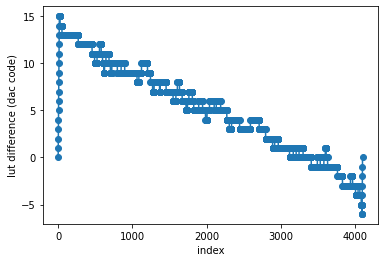

In [9]:
ChV.CompareOnboardLUTto()

In [10]:
ChU = OutputChannel('U')

This channel has an existing non-trivial saved calibration
The average difference between these two LUTs is 4.88 codes


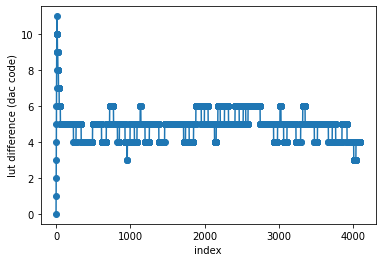

In [11]:
ChU.CompareOnboardLUTto()

# Channel V Calibration

Progress: [####################] 100.0%
R = 9.92375e-02 +- 1.68162e-05 Ohms


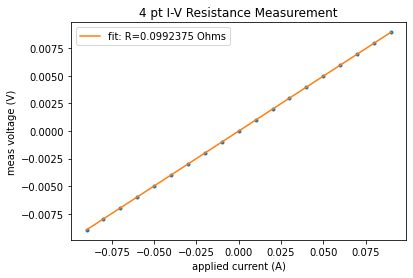

In [12]:
ChV.SweepI_MeasV(-90e-3, 90e-3, 10e-3)

### Check if the channel has already been cal'd

In [141]:
ChV.DownloadCalData()

This channel has an existing non-trivial saved calibration


array([   0,    0,    0, ..., 4095, 4095, 4095])

### Determine if you want to reset the cal or not

In [13]:
ChV.ResetCal()

Total elapsed time = 0.7036213874816895 seconds


In [14]:
# And verify that it's been reset
ChV.DownloadCalData()

This channel has not yet been calibrated (code = index)


array([   0,    1,    2, ..., 4093, 4094, 4095])

Progress: [####################] 100.0%
elapsed time = 122.42510437965393


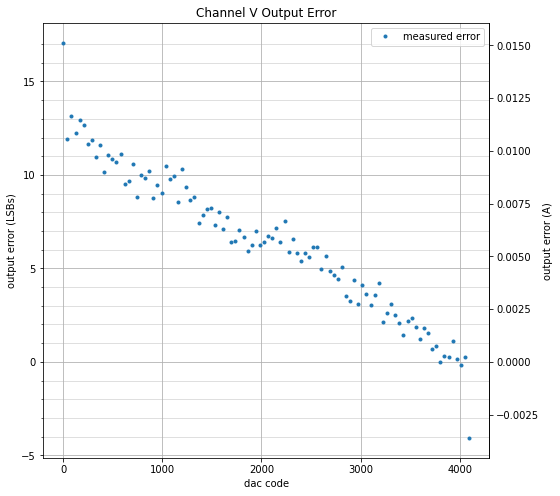

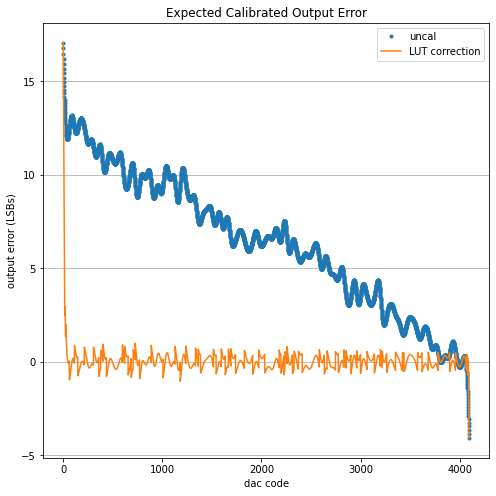

In [15]:
testCodes = np.linspace(0, ChV.numCodes-1, 100, dtype=int)
V_V = ChV.MeasVoltageVsDacCode(testCodes)
ChV.PlotCurrentError(testCodes, V_V)

ChV.CreateLUT(testCodes, V_V)
ChV.ApplyLUTCorrection()

In [16]:
ChV.EvaluatePassFail(testCodes, V_V)

rms error = 7.463 LSBs
Calibration Failed


False

### Extract the full-scale current output of this channel

In [17]:
# Full-scale current, in Amps
(max(ChV.txFun) - min(ChV.txFun))/2

1.8053672910073257

In [18]:
ChV.HowlandGain*ChV.Vref/2

1.8151815181518152

## OPTIONAL: Experimental Verification of the Calibration

Before actually uploading the 4096-element LUT to the controller, can simulate a calibrated DAC by commanding codes that have been corrected by the LUT. This step is not so necessary now that uploads can be performed much more quickly with the $DAA command

Progress: [####################] 100.0%
elapsed time = 126.16760444641113


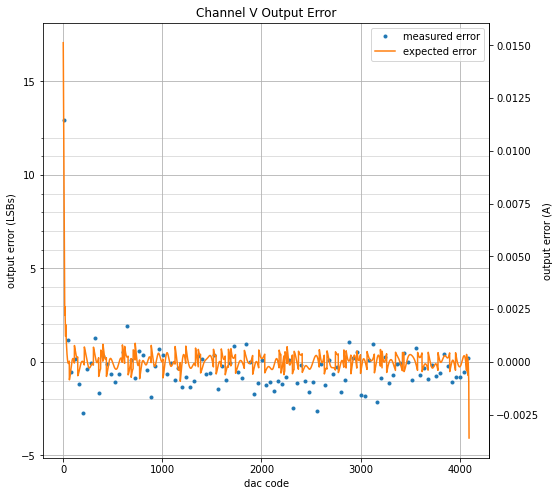

In [19]:
verifyCodes = np.arange(3, ChV.numCodes-1, 40, dtype=int)
V_V_corrected = ChV.MeasVoltageVsDacCode(ChV.LUT[verifyCodes])
ChV.PlotCurrentError(verifyCodes, V_V_corrected)

In [20]:
ChV.EvaluatePassFail(verifyCodes, V_V_corrected)

rms error = 1.614 LSBs
Calibration Passed!


## Upload LUTs to SR542

This channel has not yet been calibrated (code = index)
The average difference between these two LUTs is -6.37 codes


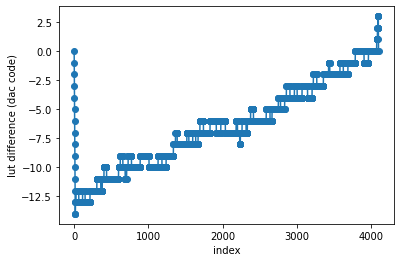

In [21]:
ChV.CompareOnboardLUTto(ChV.LUT)

In [22]:
ChV.UploadCalData()

Total elapsed time = 0.7054710388183594 seconds


## Verify the Uploaded LUT

In [24]:
# Define the measurement sweep
verifyCodes = np.linspace(3, ChU.numCodes-1, 200, dtype=int)
V_V_cal = ChV.MeasVoltageVsDacCode(verifyCodes)

Progress: [####################] 100.0%
elapsed time = 244.9767677783966


In [25]:
# The original test codes and uncal'd measurement
ChV.EvaluatePassFail(testCodes, V_V)

rms error = 7.463 LSBs
Calibration Failed


False

In [26]:
# The verification codes, and cal'd measurement
ChV.EvaluatePassFail(verifyCodes, V_V_cal)

rms error = 1.592 LSBs
Calibration Passed!


True

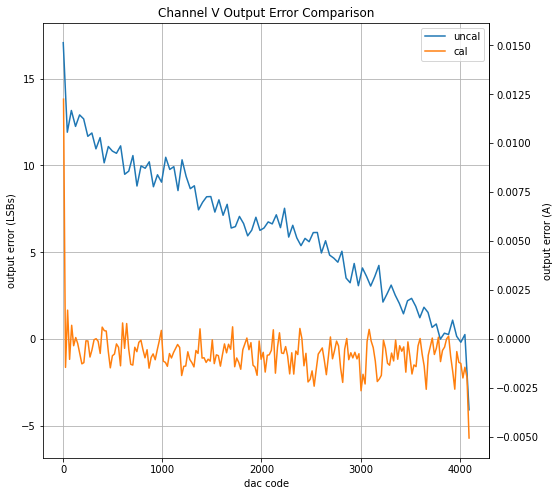

In [27]:
ChV.PlotComparison([testCodes, verifyCodes], [V_V, V_V_cal], ['uncal', 'cal'])

### And if everything looks good, save the cal table to NVM:

In [28]:
ChV.WriteCalDataToNvm()
ChV.SaveCalData()

# Channel U Calibration

In [29]:
ChU = OutputChannel('U')
ChU.DownloadCalData()

This channel has an existing non-trivial saved calibration


array([   0,    0,    0, ..., 4089, 4090, 4091])

In [30]:
# If you want to perform a fresh-cal, need to reset the existing cal table in the controller's RAM
ChU.ResetCal()

Total elapsed time = 0.7052345275878906 seconds


Progress: [####################] 100.0%
elapsed time = 126.16406273841858
rms error = 1.619 LSBs
Calibration Passed!
Total elapsed time = 0.7045607566833496 seconds


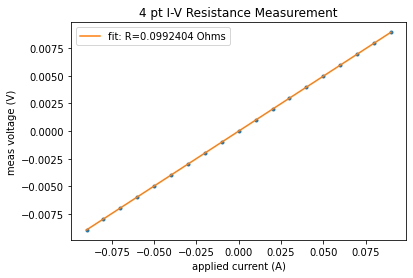

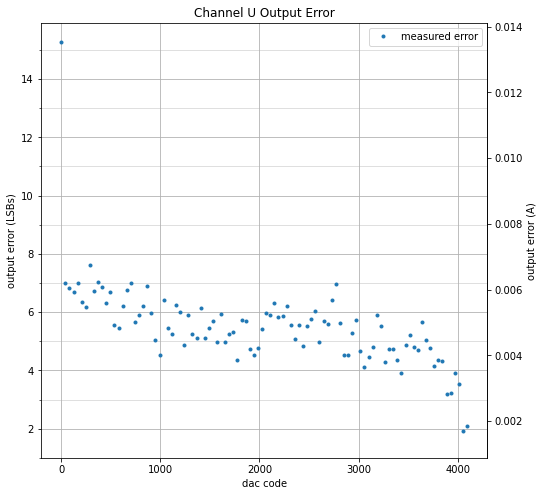

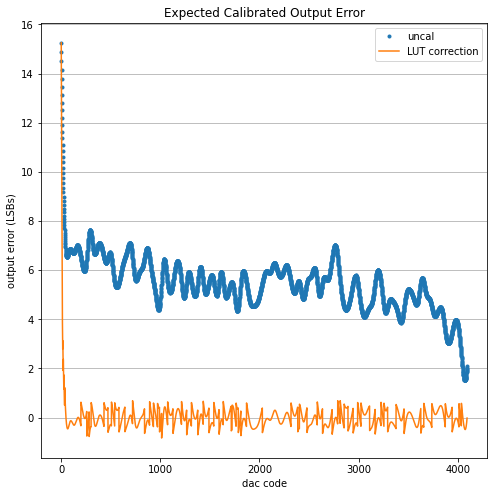

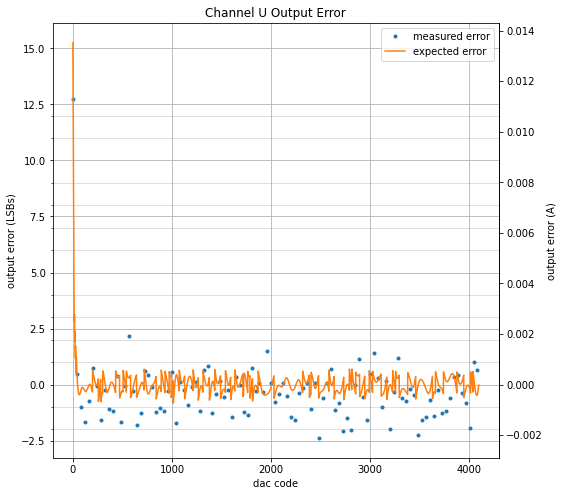

In [33]:
ChU.SweepI_MeasV(-90e-3, 90e-3, 10e-3)

testCodes = np.linspace(0, ChU.numCodes-1, 100, dtype=int)
V_U = ChU.MeasVoltageVsDacCode(testCodes)
ChU.PlotCurrentError(testCodes, V_U)

ChU.CreateLUT(testCodes, V_U)
ChU.ApplyLUTCorrection()

verifyCodes = np.arange(3, ChU.numCodes-1, 40, dtype=int)
V_U_corrected = ChU.MeasVoltageVsDacCode(ChU.LUT[verifyCodes])
ChU.PlotCurrentError(verifyCodes, V_U_corrected)

if ChU.EvaluatePassFail(verifyCodes, V_U_corrected):    
    ChU.UploadCalData()

## Verify the uploaded LUTs

In [35]:
ChU.DownloadCalData()

This channel has an existing non-trivial saved calibration


array([   0,    0,    0, ..., 4091, 4092, 4093])

In [36]:
# Define the measurement sweepa
verifyCodes = np.linspace(3, ChU.numCodes-1, 200, dtype=int)

V_U_cal = ChU.MeasVoltageVsDacCode(verifyCodes)

Progress: [####################] 100.0%
elapsed time = 244.95599246025085


In [37]:
# Before cal
ChU.EvaluatePassFail(testCodes, V_U)

rms error = 5.671 LSBs
Calibration Failed


False

In [38]:
# After cal
ChU.EvaluatePassFail(verifyCodes, V_U_cal)

rms error = 1.338 LSBs
Calibration Passed!


True

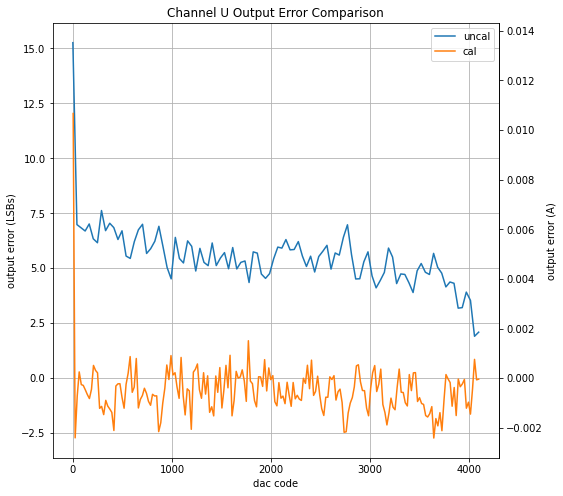

In [39]:
ChU.PlotComparison([testCodes, verifyCodes], [V_U, V_U_cal], ['uncal', 'cal'])

### And if everything looks good, save the cal table to NVM:

In [40]:
ChU.WriteCalDataToNvm()
ChU.SaveCalData()

# Reproducibility Tests

In [56]:
ChV.R

0.09920144376333344

In [83]:
testCodes = np.linspace(0, ChV.numCodes-1, 100, dtype=int)

numTrials = 6

V = []
for i in range(numTrials):
    V.append(ChV.MeasVoltageVsDacCode(testCodes))    
    
V_avg = np.mean(V, axis=0)
V.append(V_avg)

ChV.PlotComparison([testCodes, testCodes, testCodes, testCodes], V, ['trial1', 'trial2', 'trial3', 'avg'])

Progress: [####################] 100.0%
elapsed time = 122.56045484542847
Improper number of measurements


In [72]:
def MeasVoltageToCurrentError(codes, V_meas, R, idealCurrent, LSB_A):
    I_A = V_meas/R
    I_A_error = I_A - idealCurrent(codes)
    I_c_error = I_A_error/LSB_A
    
    return I_c_error

In [84]:
I_c = MeasVoltageToCurrentError(testCodes, V, ChV.R, ChV.idealCurrent, ChV.LSB_A)
I_c

array([[ 1.68947275e+01,  1.12538700e+01,  1.25429870e+01,
         1.20722101e+01,  1.25600681e+01,  1.18308313e+01,
         1.03046901e+01,  1.06390066e+01,  1.08606123e+01,
         1.13741727e+01,  1.09667133e+01,  1.09760663e+01,
         1.07475226e+01,  9.91463965e+00,  9.84864360e+00,
         9.73883858e+00,  1.00920919e+01,  9.77451528e+00,
         8.93070247e+00,  9.27166106e+00,  9.16358327e+00,
         8.99649023e+00,  1.00129694e+01,  9.77499597e+00,
         8.84632932e+00,  9.38996452e+00,  9.54528352e+00,
         7.82574755e+00,  9.79622876e+00,  9.22802400e+00,
         8.75742044e+00,  9.26165690e+00,  8.67449262e+00,
         7.95226491e+00,  7.76516144e+00,  7.72531332e+00,
         8.76046658e+00,  7.33386156e+00,  7.04706191e+00,
         7.99102746e+00,  7.37128282e+00,  6.68539024e+00,
         7.27484790e+00,  6.64450549e+00,  5.95208757e+00,
         6.51063147e+00,  6.19076467e+00,  7.51969427e+00,
         6.52163120e+00,  5.96531488e+00,  6.56342625e+0

In [88]:
len(I_c)

7

Text(0, 0.5, 'output error (A)')

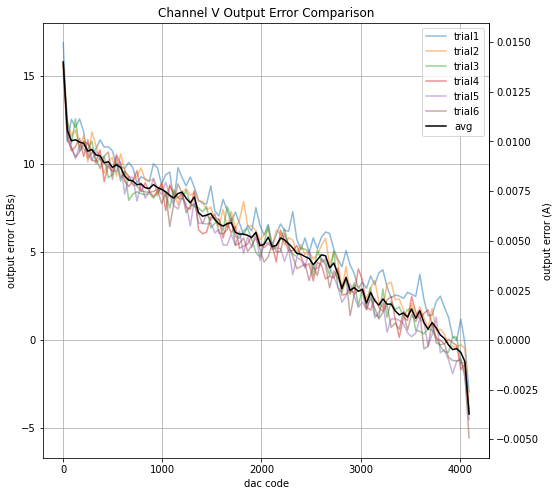

In [90]:
fig, axL = plt.subplots(figsize=(8,8))

axL.plot(testCodes, I_c[0], alpha=0.5, label='trial1')
axL.plot(testCodes, I_c[1], alpha=0.5, label='trial2')
axL.plot(testCodes, I_c[2], alpha=0.5, label='trial3')
axL.plot(testCodes, I_c[3], alpha=0.5, label='trial4')
axL.plot(testCodes, I_c[4], alpha=0.5, label='trial5')
axL.plot(testCodes, I_c[5], alpha=0.5, label='trial6')
axL.plot(testCodes, I_c[6], color='black', alpha=1.0, label='avg')

axL.set_xlabel('dac code')
axL.set_ylabel('output error (LSBs)')
axL.grid('y')
axL.legend()
axL.set_title(f'Channel V Output Error Comparison')

axR = axL.secondary_yaxis('right', functions=(ChV.LsbToCurrent, ChV.CurrentToLsb))        
axR.set_ylabel('output error (A)')

In [92]:
len(V[0:-1])

6

In [97]:
np.mean(np.std(I_c[0:-1], axis=0))

0.643548292479235

## Check sweep-direction dependence

Progress: [####################] 100.0%
elapsed time = 122.44384980201721


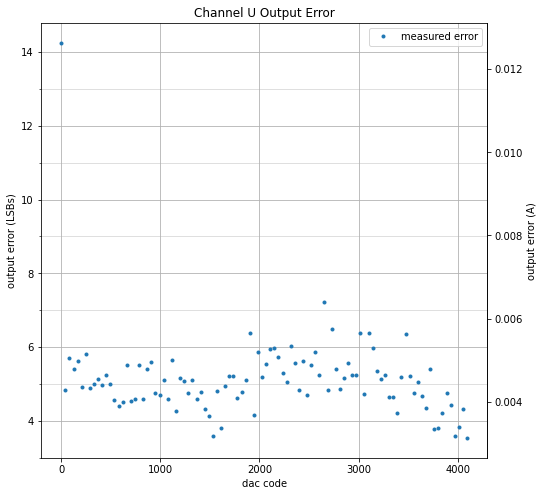

In [29]:
testCodes = np.linspace(0, ChU.numCodes-1, 100, dtype=int)
V_U_upSweep = ChU.MeasVoltageVsDacCode(testCodes)
ChU.PlotCurrentError(testCodes, V_U_upSweep)

Progress: [####################] 100.0%
elapsed time = 122.50920629501343


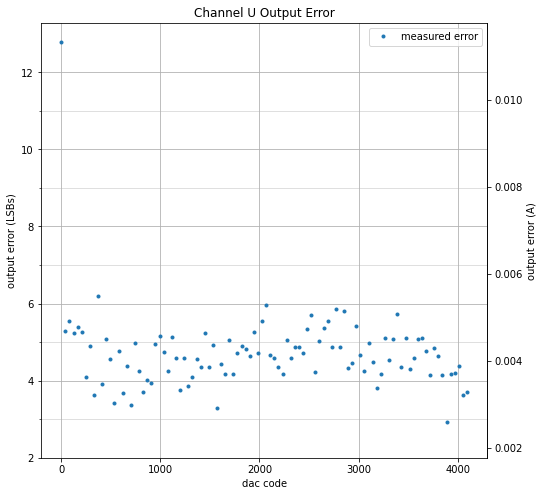

In [30]:
V_U_dnSweep = ChU.MeasVoltageVsDacCode(np.flip(testCodes))
ChU.PlotCurrentError(testCodes, np.flip(V_U_dnSweep))

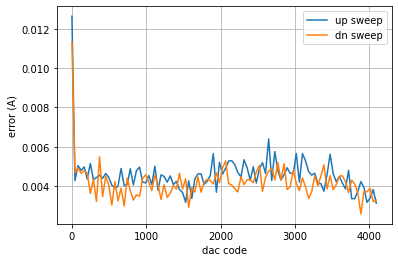

In [31]:
plt.plot(testCodes, V_U_upSweep/ChU.R - ChU.idealCurrent(testCodes), label='up sweep')
plt.plot(testCodes, np.flip(V_U_dnSweep)/ChU.R - ChU.idealCurrent(testCodes), label='dn sweep')
plt.legend()
plt.xlabel('dac code')
plt.ylabel('error (A)')
plt.grid()

In [43]:
serialQry(sr542, 'LERR?')

'106'